# Economic Analysis with Pandas

In [6]:
!pip install fredapi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import config

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_key = config.FRED_API_KEY

# 1. Create the Fred Object

In [4]:
fred = Fred(api_key=fred_key)

# 2. Search for economic data!

In [5]:
sp_search = fred.search('S&P', order_by='popularity')


In [8]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2025-03-11,2025-03-11,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2025-03-07,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2025-03-10 09:06:06-05:00,92,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2025-03-11,2025-03-11,S&P CoreLogic Case-Shiller U.S. National Home ...,1987-01-01,2024-12-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2025-02-25 08:11:20-06:00,88,"For more information regarding the index, plea..."
SP500,SP500,2025-03-11,2025-03-11,S&P 500,2015-03-11,2025-03-10,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2025-03-10 19:11:20-05:00,83,The observations for the S&P 500 represent the...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2025-03-11,2025-03-11,ICE BofA US High Yield Index Effective Yield,1996-12-31,2025-03-07,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2025-03-10 09:06:09-05:00,82,This data represents the effective yield of th...
BAMLC0A0CM,BAMLC0A0CM,2025-03-11,2025-03-11,ICE BofA US Corporate Index Option-Adjusted Sp...,1996-12-31,2025-03-07,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2025-03-10 09:14:01-05:00,78,The ICE BofA Option-Adjusted Spreads (OASs) ar...


# 3. Pull Raw Data & Plot

In [8]:
sp500 = fred.get_series(series_id='SP500')

<Axes: title={'center': 'S&P 500'}>

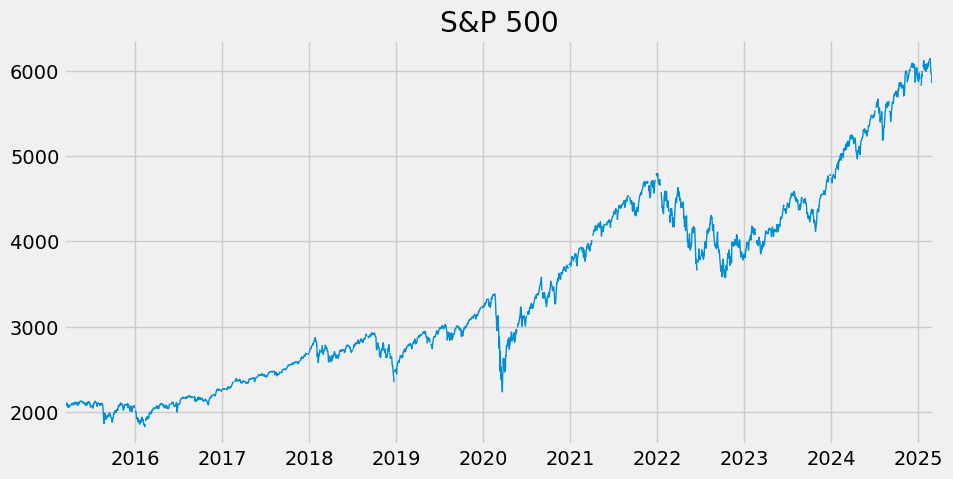

In [14]:
sp500.plot(figsize=(10,5), title='S&P 500', lw=1)

# 4. Pull and Join Multiple Data Series

In [6]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [24]:
 unemp_df.loc[unemp_df['id'].str.contains('U2RATE')]

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
U2RATE,U2RATE,2025-03-12,2025-03-12,Unemployment Rate - Job Losers (U-2),1967-01-01,2025-02-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2025-03-07 07:46:28-06:00,53,The series comes from the 'Current Population ...


In [7]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name = myid)
    all_results.append(results)
unemp_results = pd.concat(all_results, axis=1).drop(['U2RATE','LNS14000006','M0892AUSM156SNBR', 'LNS14000024','LNS14000031','M0892BUSM156SNBR', 'LNS14000002','LNS14000009','LNS14000003','LNS14000001','LNS14027660','LNS14027662','LNS14024887','LRUN64TTUSM156S','LNS14032183','LNS14000012', 'LNS14027659'], axis=1)

In [31]:
unemp_states = unemp_results.drop('UNRATE', axis =1)
unemp_states = unemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in','').to_dict()
unemp_states.columns = [id_to_state[c] for c in unemp_states.columns] #Changes Fred state id to state title

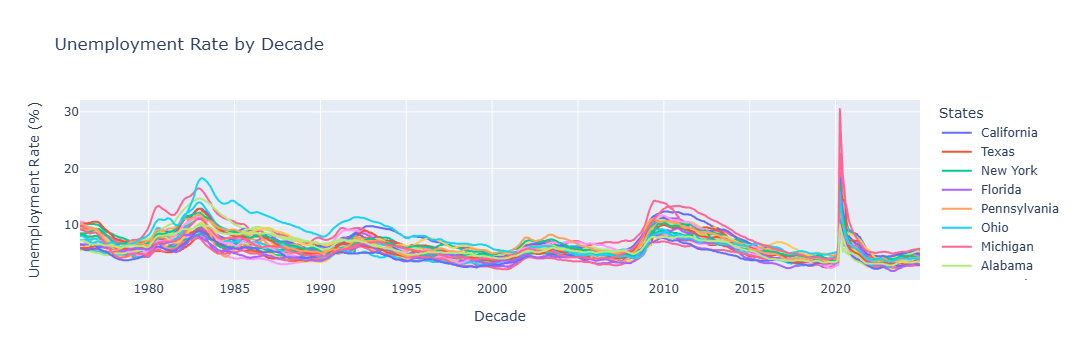

In [32]:
#States Unemployment Rate Plot
fig = px.line(unemp_states, title='Unemployment Rate by Decade', labels={"variable": "States"})

# Update the x and y axis titles
fig.update_layout(
    
    xaxis_title='Decade',  # Set the x-axis title
    yaxis_title='Unemployment Rate (%)'  # Set the y-axis title
)

# Show the plot
fig.show()

## Pull April 2020 Unemployment Rate per State

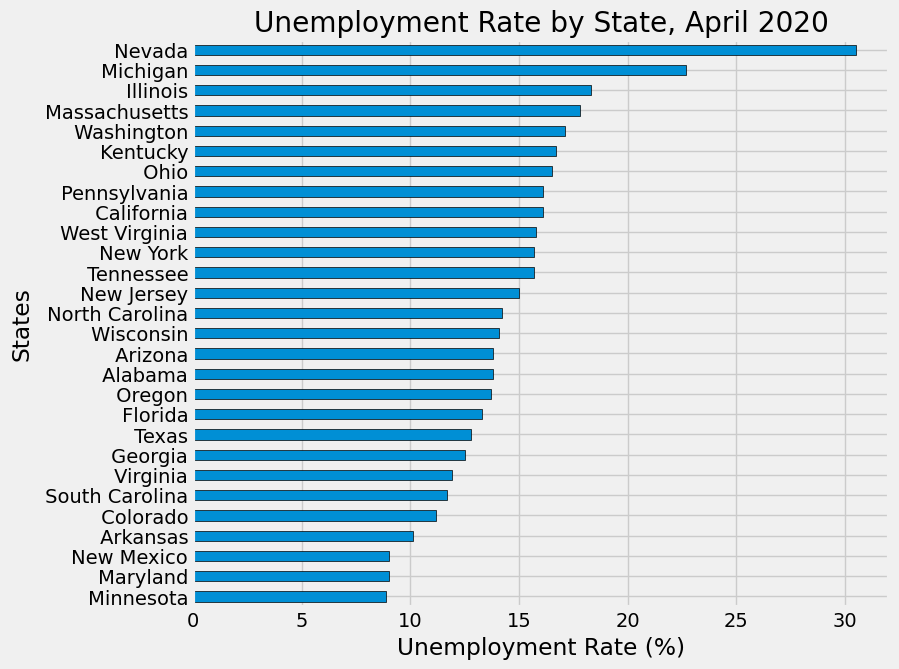

In [10]:
ax = unemp_states.loc[unemp_states.index == '2020-04-01'].T \
.sort_values('2020-04-01') \
.plot(kind='barh', figsize=(8,7), title='Unemployment Rate by State, April 2020', edgecolor='black')

ax.set_ylabel('States')
ax.set_xlabel('Unemployment Rate (%)')
ax.legend().remove()
plt.show()

# Pull Participation Rate

In [18]:
part_df = fred.search('participation rate state', filter=('frequency', 'Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
part_df

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
CIVPART,CIVPART,2025-03-14,2025-03-14,Labor Force Participation Rate,1948-01-01,2025-02-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2025-03-07 07:48:23-06:00,84,The series comes from the 'Current Population ...
LNS11300060,LNS11300060,2025-03-14,2025-03-14,Labor Force Participation Rate - 25-54 Yrs.,1948-01-01,2025-02-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2025-03-07 07:48:21-06:00,70,The series comes from the 'Current Population ...
LNS11300002,LNS11300002,2025-03-14,2025-03-14,Labor Force Participation Rate - Women,1948-01-01,2025-02-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2025-03-07 07:48:22-06:00,66,To obtain estimates of women worker employment...
LNS11300001,LNS11300001,2025-03-14,2025-03-14,Labor Force Participation Rate - Men,1948-01-01,2025-02-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2025-03-07 07:48:22-06:00,61,The series comes from the 'Current Population ...
LNS11324230,LNS11324230,2025-03-14,2025-03-14,Labor Force Participation Rate - 55 Yrs. & over,1948-01-01,2025-02-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2025-03-07 07:48:21-06:00,54,The series comes from the 'Current Population ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LRIN74MAUSM156S,LRIN74MAUSM156S,2025-03-14,2025-03-14,Infra-Annual Labor Statistics: Inactivity Rate...,1981-01-01,2025-01-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2025-02-17 13:49:07-06:00,1,OECD Data Filters: REF_AREA: USA MEASURE: OLF...
LRIN64MAUSM156S,LRIN64MAUSM156S,2025-03-14,2025-03-14,Infra-Annual Labor Statistics: Inactivity Rate...,1977-01-01,2025-01-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2025-02-17 13:49:12-06:00,1,OECD Data Filters: REF_AREA: USA MEASURE: OLF...
LRIN64FEUSM156S,LRIN64FEUSM156S,2025-03-14,2025-03-14,Infra-Annual Labor Statistics: Inactivity Rate...,1977-01-01,2025-01-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2025-02-17 13:49:15-06:00,1,OECD Data Filters: REF_AREA: USA MEASURE: OLF...


In [19]:
part_df = part_df['title'].str.replace('Labor Force Participation Rate for ', '')
valid_states = [
    'California', 'Alabama', 'New York', 'Texas', 'Florida', 'Kentucky', 'Michigan', 'Mississippi',
    'Texas', 'Massachusetts', 'Minnesota', 'Maryland', 'West Virginia', 'Tennessee', 'Maine', 'Illinois',
    'North Carolina', 'Georgia', 'Louisiana', 'South Carolina', 'Colorado', 'Utah', 'Virginia', 'Indiana',
    'Missouri', 'New Jersey', 'Iowa', 'Alaska', 'Washington', 'Arizona', 'New Mexico', 'Idaho', 'Arkansas',
    'Oklahoma', 'Nebraska', 'Hawaii', 'Nevada', 'Montana', 'Oregon', 'New Hampshire', 'Vermont', 'Connecticut',
    'North Dakota', 'South Dakota', 'Kansas', 'Rhode Island', 'District Of Columbia', 'Delaware', 'Wyoming'
]

part_df = part_df[part_df.isin(valid_states)]
part_id_to_state = part_df.to_dict()
all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name = myid)
    all_results.append(results)
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

# Plot Unemployment vs Participation 

In [34]:
unemp_states.columns = unemp_states.columns.str.strip()  # Removes any leading/trailing spaces in column names

In [82]:
unemp_columns = set(unemp_states.columns)
part_columns = set(part_states.columns)

# Find the intersection of the two sets (columns that match)
common_columns = unemp_columns.intersection(part_columns)

# Get the number of matching columns
num_common_columns = len(common_columns)

# Print the result
print(f"Number of matching columns: {num_common_columns}")

Number of matching columns: 25


Text(0.5, 1.0, 'New York: Unemployment vs Participation')

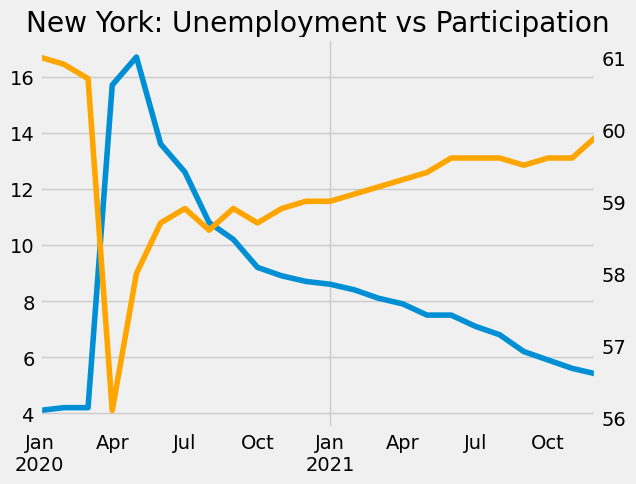

In [56]:
fig, ax = plt.subplots()
ax2 =ax.twinx()
unemp_states.query('index >= 2020 and index < 2022')['New York'].plot(ax=ax, label='Unemployment')
part_states.query('index >= 2020 and index < 2022')['New York'].plot(ax=ax2, label='Participation', color='Orange')
ax2.grid(False)
ax.set_title('New York: Unemployment vs Participation')

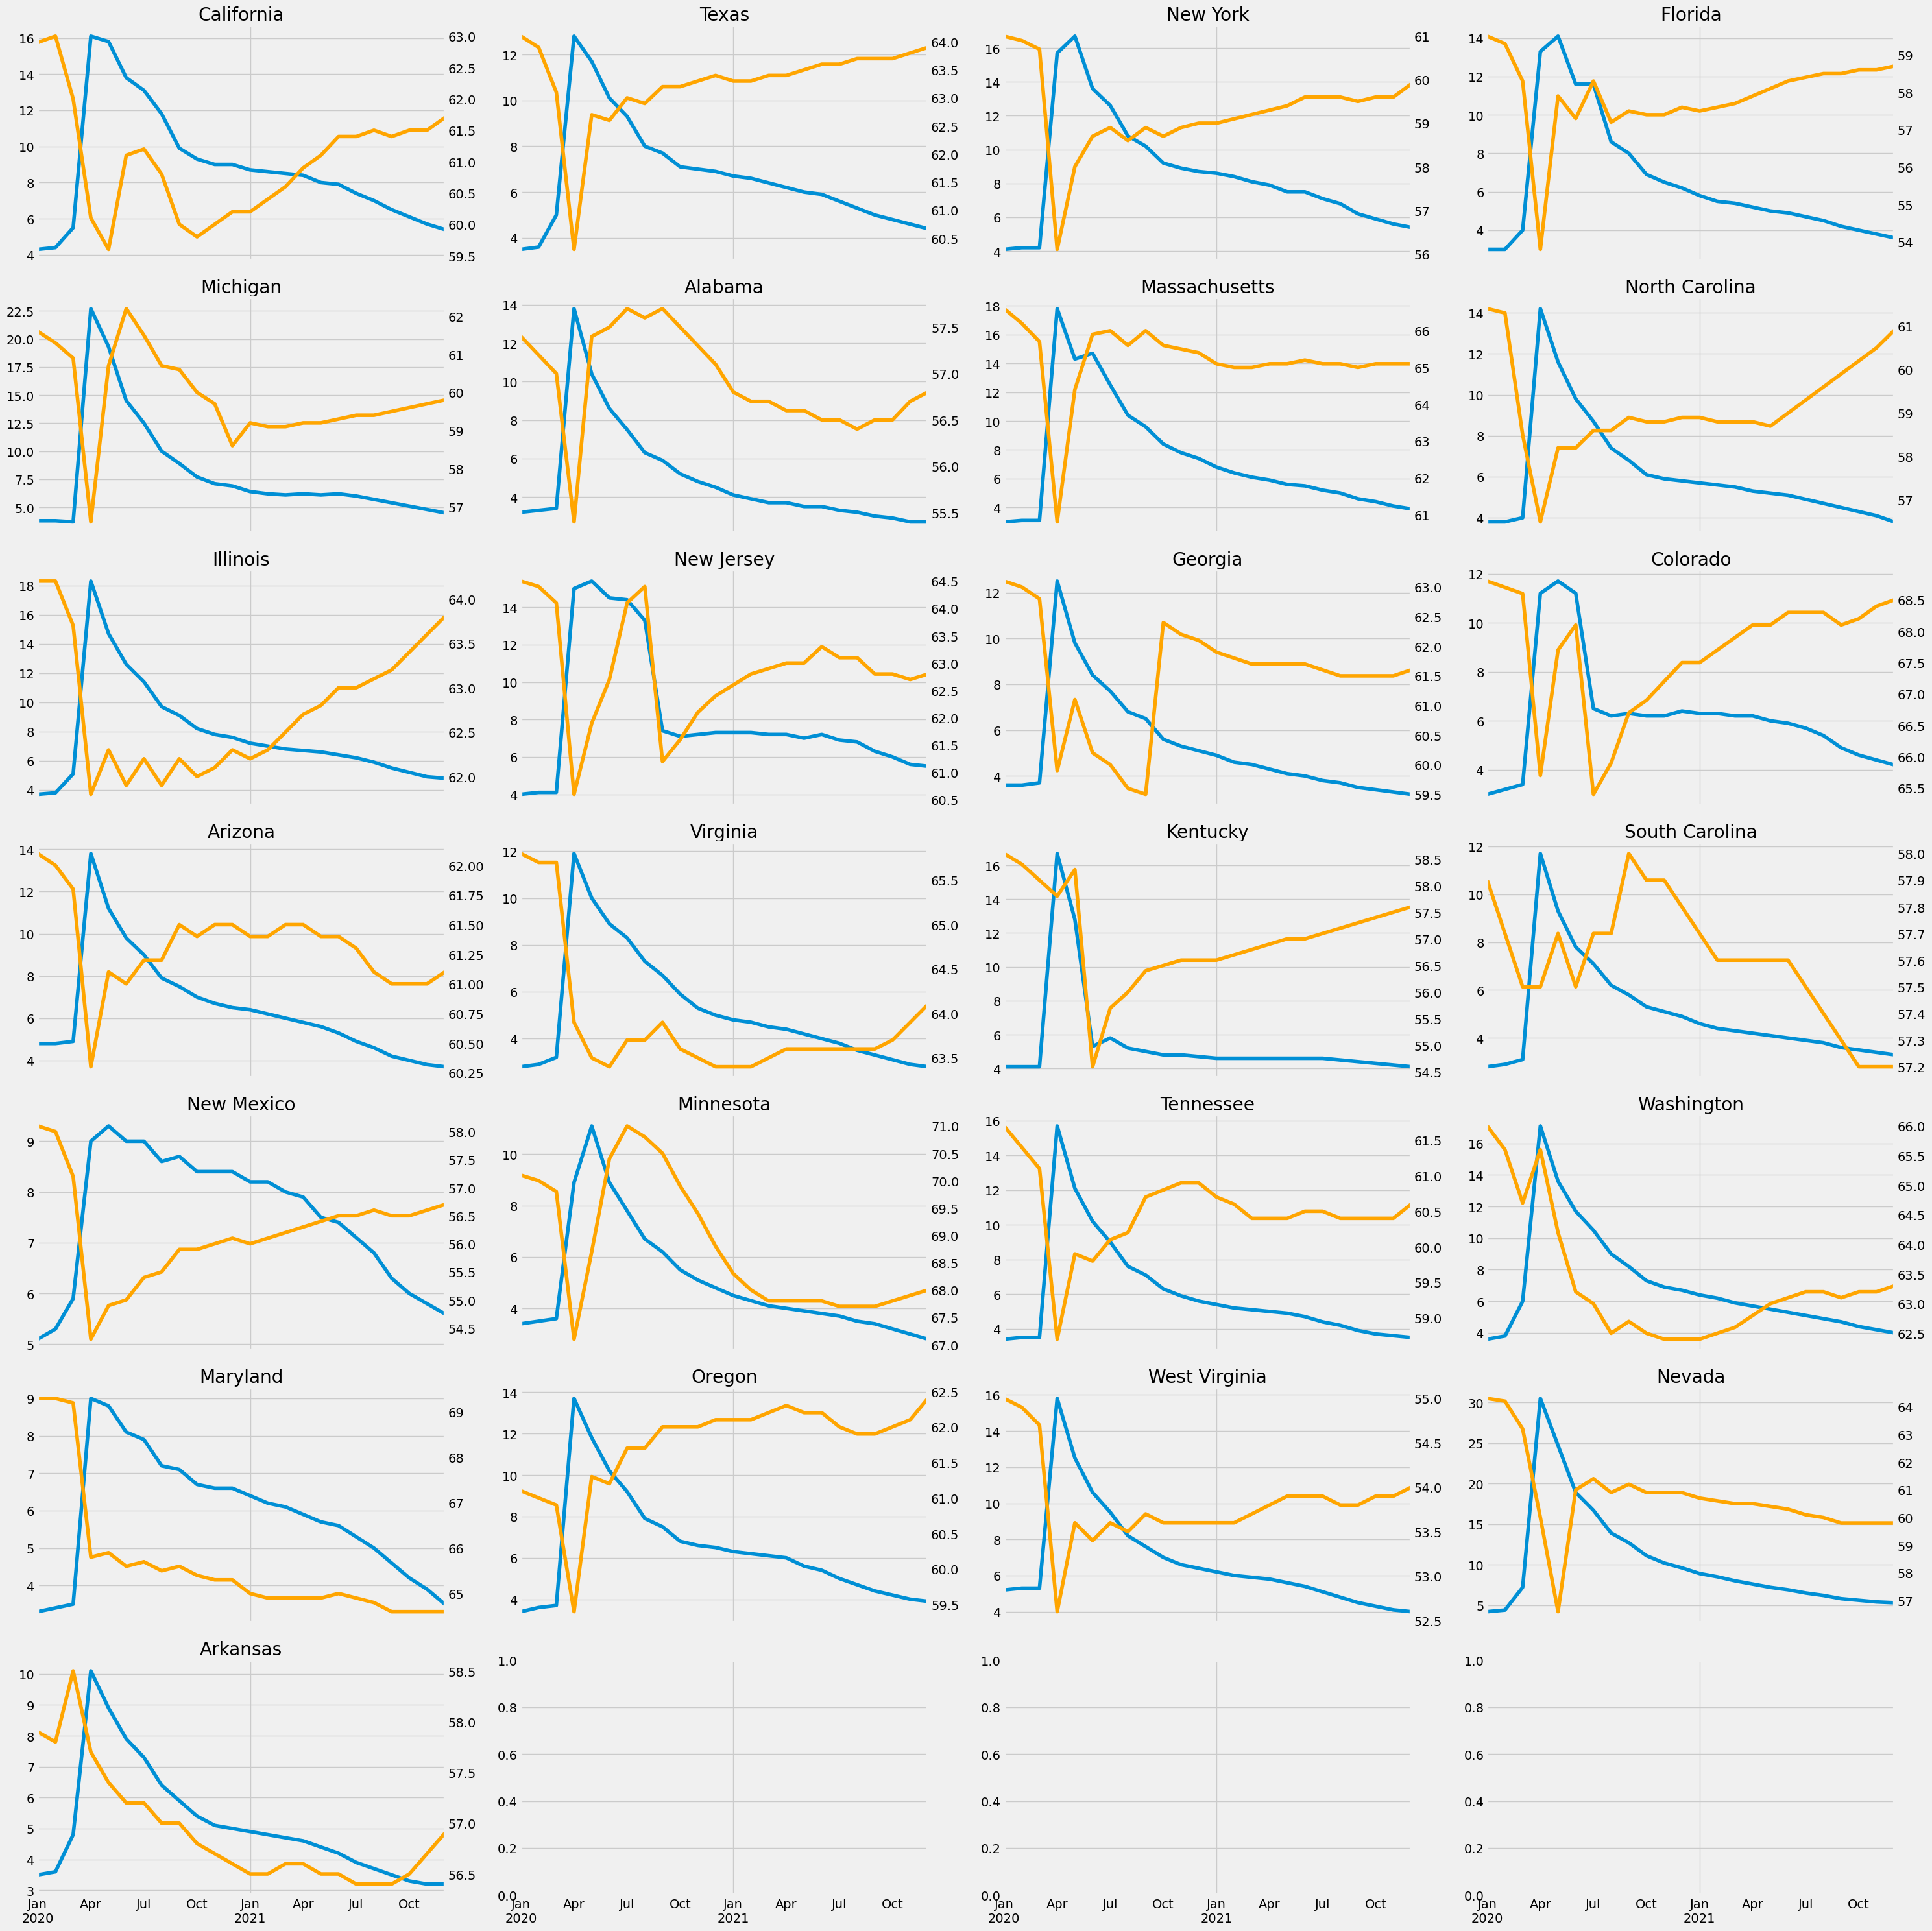

In [83]:
fig, axs = plt.subplots(7, 4, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i=0
for states in unemp_states:
    if states == 'Pennsylvania' or states == 'Ohio' or states == 'Wisconsin':
        continue
    ax2 =axs[i].twinx()
    unemp_states.query('index >= 2020 and index < 2022')[states].plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2022')[states].plot(ax=ax2, label='Participation', color='Orange')
    ax2.grid(False)
    axs[i].set_title(states)
    i+=1
plt.tight_layout()
plt.show()